<br></br>
# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import json
from sklearn.utils._show_versions import show_versions
from threadpoolctl import threadpool_info

<br></br>
# Benchmark environment

In [2]:
with open("results/env_info.txt") as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=2))

FileNotFoundError: [Errno 2] No such file or directory: 'results/env_info.txt'

# Gradient Boosting Classification Benchmarks

In [24]:
TIME_BUDGET = 300

In [25]:
df_skl = pd.read_csv("results/benchmarking/sklearn_HistGradientBoostingClassifier.csv")

In [26]:
df_lgbm = pd.read_csv("results/benchmarking/lightgbm_LGBMClassifier.csv")

In [27]:
df_xgb = pd.read_csv("results/benchmarking/xgboost_XGBClassifier.csv")

In [28]:
df_xgb

,estimator,function,n_samples_train,n_samples,n_features,hyperparams_digest,dataset_digest,mean_time,stdev_time,throughput,latency,learning_rate,max_bin,max_leaf_nodes,min_samples_leaf,n_estimators,tree_method,use_label_encoder,validate_parameters,accuracy_score
0,XGBClassifier,fit,100000,100000,100,f771bbcd034567f208dfa424be5ee3ae,cb16edecad38f292756cdc5794a48caa,109.412350,0.0,0.000366,0.002188,0.05,255,5,1000,1000,hist,False,True,NaN
1,XGBClassifier,predict,100000,1000,100,f771bbcd034567f208dfa424be5ee3ae,cb16edecad38f292756cdc5794a48caa,0.035242,0.0,0.022700,0.000035,0.05,255,5,1000,1000,hist,False,True,0.791
2,XGBClassifier,fit,100000,100000,100,586c0d02aaa87b8b620578eda9c91479,cb16edecad38f292756cdc5794a48caa,9.794476,0.0,0.004084,0.000196,0.10,32,5,20,100,hist,False,True,NaN
3,XGBClassifier,predict,100000,1000,100,586c0d02aaa87b8b620578eda9c91479,cb16edecad38f292756cdc5794a48caa,0.010254,0.0,0.078016,0.000010,0.10,32,5,20,100,hist,False,True,0.770
4,XGBClassifier,fit,100000,100000,100,09027116f0f7489de2cb9fa8281d52c4,cb16edecad38f292756cdc5794a48caa,85.624451,0.0,0.000467,0.001712,0.01,255,20,20,300,hist,False,True,NaN
5,XGBClassifier,predict,100000,1000,100,09027116f0f7489de2cb9fa8281d52c4,cb16edecad38f292756cdc5794a48caa,0.026143,0.0,0.030601,0.000026,0.01,255,20,20,300,hist,False,True,0.760
6,XGBClassifier,fit,100000,100000,100,7170fdb2309ea1a7f476ef271b92bb5b,cb16edecad38f292756cdc5794a48caa,28.890077,0.0,0.001385,0.000578,0.10,64,20,20,1000,hist,False,True,NaN
7,XGBClassifier,predict,100000,1000,100,7170fdb2309ea1a7f476ef271b92bb5b,cb16edecad38f292756cdc5794a48caa,0.019789,0.0,0.040427,0.000020,0.10,64,20,20,1000,hist,False,True,0.782
8,XGBClassifier,fit,100000,100000,100,014bad9de0b76cbab3db9d79e2dccc53,cb16edecad38f292756cdc5794a48caa,29.190233,0.0,0.001370,0.000584,0.10,64,50,2,300,hist,False,True,NaN
9,XGBClassifier,predict,100000,1000,100,014bad9de0b76cbab3db9d79e2dccc53,cb16edecad38f292756cdc5794a48caa,0.026003,0.0,0.030766,0.000026,0.10,64,50,2,300,hist,False,True,0.782


In [29]:
def compute_cumulated(fit_times, scores):
    cumulated_fit_times = fit_times.cumsum()
    best_val_score_so_far = pd.Series(scores).cummax()
    return cumulated_fit_times, best_val_score_so_far

In [30]:
fit_times_skl = df_skl[df_skl["function"] == "fit"]["mean_time"].values
fit_times_lgbm = df_lgbm[df_lgbm["function"] == "fit"]["mean_time"].values
fit_times_xgb = df_xgb[df_xgb["function"] == "fit"]["mean_time"].values
scores_skl = df_skl[df_skl["function"] == "predict"]["accuracy_score"].values
scores_lgbm = df_lgbm[df_lgbm["function"] == "predict"]["accuracy_score"].values
scores_xgb = df_xgb[df_xgb["function"] == "predict"]["accuracy_score"].values

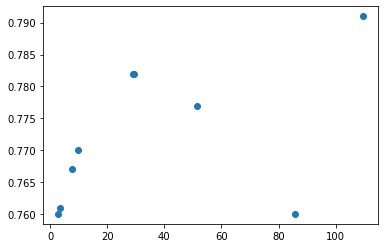

In [72]:
plt.scatter(fit_times_xgb, scores_xgb)

In [31]:
cumulated_fit_times_skl, best_val_score_so_far_skl = compute_cumulated(fit_times_skl, scores_skl)
cumulated_fit_times_lgbm, best_val_score_so_far_lgbm = compute_cumulated(fit_times_lgbm, scores_lgbm)
cumulated_fit_times_xgb, best_val_score_so_far_xgb = compute_cumulated(fit_times_xgb, scores_xgb)

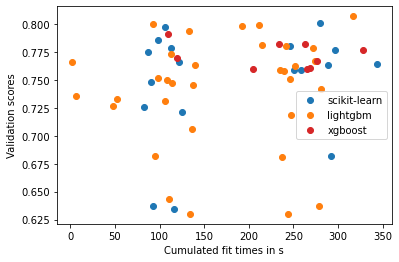

In [32]:
plt.scatter(cumulated_fit_times_skl, scores_skl, c="tab:blue", label="scikit-learn")
plt.scatter(cumulated_fit_times_lgbm, scores_lgbm, c="tab:orange", label="lightgbm")
plt.scatter(cumulated_fit_times_xgb, scores_xgb, c="tab:red", label="xgboost")
plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")
plt.legend();

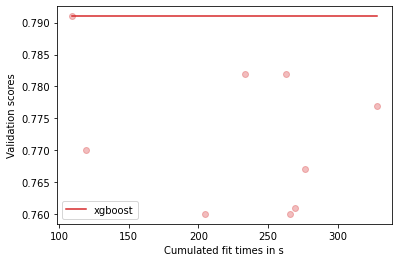

In [71]:
# plt.scatter(cumulated_fit_times_skl, scores_skl, c="tab:blue", alpha=0.3)
# plt.scatter(cumulated_fit_times_lgbm, scores_lgbm, c="tab:orange", alpha=0.3)
plt.scatter(cumulated_fit_times_xgb, scores_xgb, c="tab:red", alpha=0.3)

# plt.plot(cumulated_fit_times_skl, best_val_score_so_far_skl, c='tab:blue', label="scikit-learn")
# plt.plot(cumulated_fit_times_lgbm, best_val_score_so_far_lgbm, c='tab:orange', label="lightgbm")
plt.plot(cumulated_fit_times_xgb, best_val_score_so_far_xgb, c='tab:red', label="xgboost")

plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")

plt.legend();

In [34]:
fit_times_xgb.shape, scores_xgb.shape

((9,), (9,))

In [37]:
scores_xgb

array([0.791, 0.77 , 0.76 , 0.782, 0.782, 0.76 , 0.761, 0.767, 0.777])

In [38]:
cum_scores_xgb

0    0.791
1    0.791
2    0.791
3    0.791
4    0.791
5    0.791
6    0.791
7    0.791
8    0.791
dtype: float64

In [39]:
cum_scores_xgb_p

0    0.760
1    0.782
2    0.782
3    0.791
4    0.791
5    0.791
6    0.791
7    0.791
8    0.791
dtype: float64

In [76]:
import math

math.factorial(8)

40320

Text(0, 0.5, 'Validation scores')

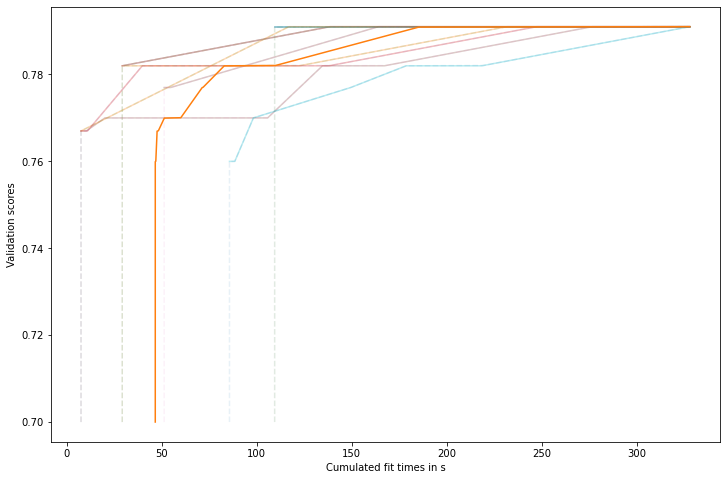

In [95]:
plt.figure(figsize=(12, 8))
grid_times = np.linspace(0, TIME_BUDGET, 1000)
cum_fit_times_xgb, cum_scores_xgb = compute_cumulated(fit_times_xgb, scores_xgb)
# plt.plot(cum_scores_xgb, cum_fit_times_xgb, label="original order", alpha=0.3)
plt.plot(cum_fit_times_xgb, cum_scores_xgb, label="original order", alpha=0.3)

baseline_score = 0.7
grid_scores = np.linspace(baseline_score, cum_scores_xgb.max(), 1000)
all_fit_times = []

for i in range(10):
    indices = rng.permutation(fit_times_xgb.shape[0])
    cum_fit_times_xgb_p, cum_scores_xgb_p = compute_cumulated(fit_times_xgb[indices], scores_xgb[indices])
    grid_fit_times = np.interp(
        grid_scores,
        cum_scores_xgb_p,
        cum_fit_times_xgb_p,
#         left=0,
        right=cum_fit_times_xgb.max(),
    )
#     plt.plot(cum_fit_times_xgb_p, cum_scores_xgb_p, label=f"perm {i}", alpha=0.3)
#     plt.plot(grid_fit_times, grid_scores, '--', label=f"interp perm {i}", alpha=0.1)
    plt.plot(cum_fit_times_xgb_p, cum_scores_xgb_p, label=f"perm {i}", alpha=0.3)
    plt.plot(grid_fit_times, grid_scores, '--', label=f"interp perm {i}", alpha=0.1)
    all_fit_times.append(grid_fit_times)

# plt.plot(grid_scores, np.mean(all_fit_times, axis=0), label=f"mean perm")
plt.plot(np.mean(all_fit_times, axis=0), grid_scores, label=f"mean perm")
plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")
# plt.ylim(0.5, 0.8)
# plt.legend(loc="best");


In [12]:
def permutated_curve(grid_times, fit_times, scores, rng):
    assert fit_times.shape == scores.shape
    assert fit_times.ndim == 1
    indices = rng.permutation(fit_times.shape[0])
    cum_fit_times, cum_scores = compute_cumulated(fit_times[indices], scores[indices])
    grid_scores = np.interp(
        grid_times,
        cum_fit_times,
        cum_scores,
        left=0,
        right=scores.max()
    )
    return grid_scores

In [13]:
rng = np.random.RandomState(1)

In [14]:
def mean_permutated_curve(fit_times, scores, seed=0, n_permutations=1000, time_budget=TIME_BUDGET):
    grid_times = np.linspace(0, time_budget, 1000)
    rng = np.random.RandomState(seed)
    grid_scores_all = []
    for _ in range(n_permutations):
        grid_scores = permutated_curve(grid_times, fit_times, scores, rng)
        grid_scores_all.append(grid_scores)
    return grid_times, np.mean(grid_scores_all, axis=0)

In [15]:
grid_times_skl, scores_skl = mean_permutated_curve(fit_times_skl, scores_skl)
grid_times_lgbm, scores_lgbm = mean_permutated_curve(fit_times_lgbm, scores_lgbm)
grid_times_xgb, scores_xgb = mean_permutated_curve(fit_times_xgb, scores_xgb)

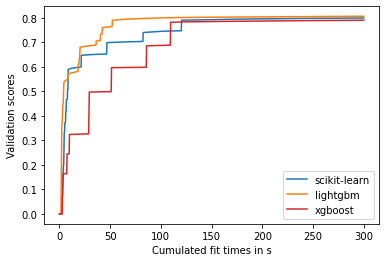

In [16]:
plt.plot(grid_times_skl, scores_skl, c='tab:blue', label="scikit-learn")
plt.plot(grid_times_lgbm, scores_lgbm, c='tab:orange', label="lightgbm")
plt.plot(grid_times_xgb, scores_xgb, c='tab:red', label="xgboost")

plt.xlabel("Cumulated fit times in s")
plt.ylabel("Validation scores")

plt.legend();